# FTP NOAA

## Get AR IDs

In [10]:
from ftplib import FTP
from sunpy.io.special import srs

from module import toSunpyMap

In [11]:

file = 'data/L1/imoa_06563_l1_20240317_12440670_emi1.fts.bz2'

In [12]:
map = toSunpyMap(file, center_disk=True)

In [13]:
latest = '/pub/latest/SRS.txt'


filename = 'pub/warehouse/' + str(map.date.datetime.year) + '/SRS/' + map.date.strftime("%Y%m%d") + 'SRS.txt'

with FTP("ftp.swpc.noaa.gov") as ftp:
    ftp.login()
    
    file_contents = []
    ftp.retrlines('RETR '+filename, file_contents.append)
    
    header, section_lines, supplementary_lines = srs.split_lines(file_contents)

    srs_table = srs.make_table(header, section_lines, supplementary_lines)

In [14]:
file_contents

[':Product: 0317SRS.txt',
 ':Issued: 2024 Mar 17 0030 UTC',
 '# Prepared jointly by the U.S. Dept. of Commerce, NOAA,',
 '# Space Weather Prediction Center and the U.S. Air Force.',
 '#',
 'Joint USAF/NOAA Solar Region Summary',
 'SRS Number 77 Issued at 0030Z on 17 Mar 2024',
 'Report compiled from data received at SWO on 16 Mar',
 '# I.  Regions with Sunspots.  Locations Valid at 16/2400Z ',
 'Nmbr Location  Lo  Area  Z   LL   NN Mag Type',
 '3606 N09W26   332  0010 Axx  01   02 Alpha',
 '3607 S17W08   314  0020 Cro  09   06 Beta',
 '3611 N28E35   271  0030 Hrx  01   01 Alpha',
 '3612 N23W68   015  0010 Axx  01   01 Alpha',
 '3613 S23W17   323  0070 Cao  06   07 Beta',
 '# IA. H-alpha Plages without Spots.  Locations Valid at 16/2400Z Mar',
 'Nmbr  Location  Lo',
 '3604  N08W83   030',
 '3608  N11W00   307',
 '3609  N06E07   300',
 '3610  S16E28   279',
 '# II. Regions Due to Return 17 Mar to 19 Mar',
 'Nmbr Lat    Lo',
 '3598 S13    194',
 '3592 S14    182',
 '3595 N20    182']

In [15]:
srs_table

ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude
,,deg,uSH,,deg,,,deg,deg
str2,int32,float64,float64,str3,float64,int32,str5,float64,float64
I,13606,332.0,10.0,Axx,1.0,2,Alpha,9.0,26.0
I,13607,314.0,20.0,Cro,9.0,6,Beta,-17.0,8.0
I,13611,271.0,30.0,Hrx,1.0,1,Alpha,28.0,-35.0
I,13612,15.0,10.0,Axx,1.0,1,Alpha,23.0,68.0
I,13613,323.0,70.0,Cao,6.0,7,Beta,-23.0,17.0
IA,13604,30.0,———,--,———,--,--,8.0,83.0
IA,13608,307.0,———,--,———,--,--,11.0,0.0
IA,13609,300.0,———,--,———,--,--,6.0,-7.0


In [16]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
import sunpy.map

date_str = '2024 Mar 23 0000 UTC'
date_obs = datetime.strptime(date_str, '%Y %b %d %H%M %Z')

In [17]:
data = np.full((10, 10), np.nan)

# Define a reference coordinate and create a header using sunpy.map.make_fitswcs_header
skycoord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=date_obs,
                    observer='earth', frame=frames.Helioprojective)

# Scale set to the following for solar limb to be in the field of view
header = sunpy.map.make_fitswcs_header(data, skycoord, scale=[220, 220]*u.arcsec/u.pixel)

# Use sunpy.map.Map to create the blank map
blank_map = sunpy.map.Map(data, header)

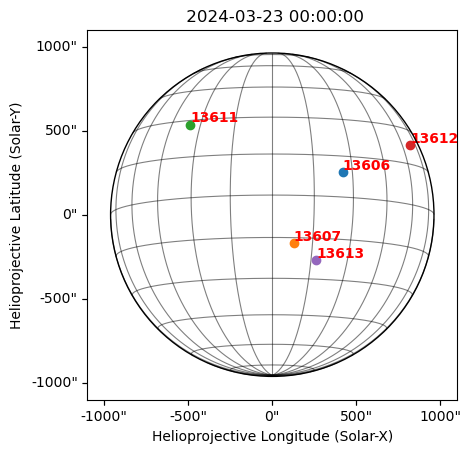

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection=blank_map)
blank_map.plot(axes=ax)
blank_map.draw_limb(axes=ax, color="k")
blank_map.draw_grid(axes=ax, color="k")

    
for region in srs_table[srs_table['ID']=='I']:
    ax.plot_coord(
        SkyCoord(region['Longitude'],
                 region['Latitude'], 
                 obstime=date_obs, 
                 observer='earth', 
                 frame=frames.HeliographicStonyhurst,
                 ).transform_to(blank_map.coordinate_frame), 'o')
    
    ax.annotate( region['Number'],
                (region['Longitude'].value, region['Latitude'].value),
                xycoords=ax.get_transform('heliographic_stonyhurst'),
                color='red',
                fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom')